# Praktikum 2020
This notebook contains all code and documentaton to read the data collected during the Bachelor Praktikum. It includes processing data from the following sources:
- Postprocessed data from Operational System including data from the rain gauge, sealevel sensor (currently broken, hence only NaNs) and water temperature profiles (all on 8min sampling interval)
- Raw data from Friedrichs System set up for the Praktikum (1m sampling interval)
- Postprocessed data from lighthouse (8m sampling interval)
- Sonic turbulence measurement sensor
- LiCor CO2 sensor

Data from the sources above is collected in a single csv file per system/device and stored in a subfolder `{basedir}/postprocessed`.

In [1]:
# import packages we need in this notebook
%matplotlib inline
import pandas as pd
import dask.dataframe as dd
from datetime import datetime, timedelta, date
import time, os
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

## Basic settings

In [18]:
start_date=datetime(2021,9,3)
end_date=datetime(2021,9,9)
basedir="/Users/jkjellsson/Downloads/praktikum_summer_2021/"
#basedir="/Users/swahl/data/praktikum2020/"
licor_file_indir=f'{basedir}/licor/'
licor_file_input=f'{basedir}/licor/licor_2021-09-02_1717'
licor_file_output=f'{basedir}/postprocessed/licor_8min.csv'

#sonic_file_input=f'{basedir}/sonic/sonicneu_all.TXT'
sonic_file_input=f'{basedir}/sonic/sonicneu2020-09-14_0813.TXT'
sonic_file_indir=f'{basedir}/sonic/'
sonic_file_output=f'{basedir}/postprocessed/sonic.csv'

friedrichs_operational_indir=f'{basedir}/friedrichs_operational/' 
friedrichs_operational_output=f'{basedir}/postprocessed/friedrichs_operational_8min.csv'

friedrichs_praktikum_indir=f'{basedir}/friedrichs_praktikum/' 
friedrichs_praktikum_output=f'{basedir}/postprocessed/friedrichs_praktikum_8min.csv'

lighthouse_operational_indir=f'{basedir}/lighthouse/' 
lighthouse_operational_output=f'{basedir}/postprocessed/lighthouse_operational_8min.csv'

###  Read Raw data from Licor CO2 and H2O sensor
Stores data at 10Hz in tab separated table.
The code below reads the data, resamples it to 8 minutes and writes the results to a `.csv` file.
Using Dask because the file can be huge (test file had 12 Mio lines)

In [3]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.217.205:8787/status,
Dashboard: http://134.245.217.205:8787/status,Workers: 1
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: False
Comm: inproc://134.245.217.205/24149/1,Workers: 1
Dashboard: http://134.245.217.205:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: inproc://134.245.217.205/24149/3,Total threads: 4
Dashboard: http://134.245.217.205:64284/status,Memory: 7.45 GiB
Nanny: None,


In [9]:
licorfiles = ['licor_2021-09-02_1435']

for file in licorfiles:
    licor_file_input = '%s/%s' % (licor_file_indir,file)
    # read start date/time from header (first line)
    with open(licor_file_input,"rb") as f:
        datetimestring = f.readline()

    f.close()
    start_date = datetime.strptime(datetimestring.decode().strip(),"%b %d %Y at %H:%M:%S")
    print(start_date)

# read file skipping the first 8 rows
df = dd.read_csv(licor_file_input,encoding = 'unicode_escape',skiprows=8,sep='\t',dtype='float')
# build the time axis
df['timestamp']=dd.to_timedelta(df['Relative Time'],unit='s') + start_date
# set timeaxis as index (needed for resample below) and drop unwanted columns
licor = df.drop(columns=['Unnamed: 0','Relative Time','Aux Input','Cooler Voltage']).set_index(df['timestamp'],drop=True,sorted=True,npartitions='auto')
#licor.head(5)

distributed.worker - WARNING - Compute Failed
Function:  subgraph_callable-0a179296-9dd7-4bdb-a1e5-10d4715f
args:      ((<Serialize: subgraph_callable-0b2e076c-488b-4128-af0d-11333fb8c71d>, <Serialize: [(<function read_block_from_file at 0x7fcca0d5e9d0>, <OpenFile '/Users/jkjellsson/Downloads/praktikum_summer_2021//licor//licor_2021-09-02_1435'>, 0, 64000000, b'\n'), None, True, False]>))
kwargs:    {}
Exception: AttributeError("'tuple' object has no attribute 'max'")

distributed.worker - WARNING - Compute Failed
Function:  subgraph_callable-0a179296-9dd7-4bdb-a1e5-10d4715f
args:      ((<Serialize: subgraph_callable-0b2e076c-488b-4128-af0d-11333fb8c71d>, <Serialize: [(<function read_block_from_file at 0x7fcca0d5e9d0>, <OpenFile '/Users/jkjellsson/Downloads/praktikum_summer_2021//licor//licor_2021-09-02_1435'>, 64000000, 64000000, b'\n'), None, False, False]>))
kwargs:    {}
Exception: AttributeError("'tuple' object has no attribute 'max'")

distributed.worker - WARNING - Compute Faile

2021-09-02 14:47:31
Dask Series Structure:
npartitions=9
    datetime64[ns]
               ...
         ...      
               ...
               ...
Name: timestamp, dtype: datetime64[ns]
Dask Name: getitem, 54 tasks


AttributeError: 'tuple' object has no attribute 'min'

In [5]:
licor_resampled = licor.resample('8min',closed='right',label='right').mean()
licor_resampled.compute().to_csv(licor_file_output,errors='replace')

In [6]:
# plt = licor_resampled.compute().plot(linestyle='None', marker=".", subplots=True, layout=(4,5),figsize=(20,11))
# licor_resampled.head(5)

###  Read Raw data from Sonic turbulence measurement sensor
The data is parsed from the complicated txt file format, and output is written to a single `.csv` file. 
We need to grep the following from the text file, all other entries shall be ignored.
```
SNC 200908135045 UTC AVE     600 SMP  10.000 AZI     0.0 SDQ     100
    x =    1.38     y =    1.62     z =    0.10     T =   20.22
 xsig =  1.7687  ysig =  1.8590  zsig =  1.0064  Tsig =  0.3664
xycov =  0.2210 xzcov = -0.4229 xTcov = -0.1911
yzcov =  0.1412 yTcov = -0.2645 zTcov =  0.0982
 psig =  1.8746  qsig =  1.7457  rsig =  1.0175
   tp =  0.8782    tq =  0.8178    tr =  0.4766
ustar =  0.6677 Tstar =  0.1471    Cd = 0.09784
  MOs =  -0.004    mf =  -0.536    hf = 114.475
    u =    1.62     v =    1.38     w =    0.10
  vel =    2.13   dir =   229.6
```

In [13]:
fields = ['T', 'x', 'y', 'z', 'Tsig', 'xsig', 'ysig', 'zsig', 
          'xTcov', 'xycov', 'xzcov', 'zTcov', 'yzcov', 'yTcov', 
          'rsig', 'psig', 'qsig', 'tr', 'tp', 'tq', 'Cd', 
          'ustar', 'Tstar', 'hf', 'MOs', 'mf', 'w', 'u', 'v', 'dir', 'vel']

sonicfiles = ['sonicneu_all.TXT']

for file in sonicfiles:
    sonic_file_input = '%s/%s' % (sonic_file_indir,file)
    rows_list = []
    d = {}
    with open(sonic_file_input,"rb") as f:
        lines = f.readlines()
        for l in lines:
            line = l.decode(errors='ignore')
            #print(line)
            if not line.startswith('x='):
                #print(line)
                if line.startswith('SNC'):
                    datetimestring=line.split()[1]
                    d['timestamp'] = datetime.strptime(datetimestring,"%y%m%d%H%M%S")
                    #print(d['timestamp'])
                else:
                    v = line.split()
                    #print(line)
                    for i in range(int(len(v)/3)):
                        j=(i-1)*3
                        d[v[j]] = float(v[j+2])
            else:
                if d: rows_list.append(d)
                d = {}
    f.close()
    df = pd.DataFrame(rows_list).replace('',np.nan)
    sonic = (df.set_index(df['timestamp'])).drop(columns=['timestamp'])[fields]
    
    sonic.to_csv(sonic_file_output)

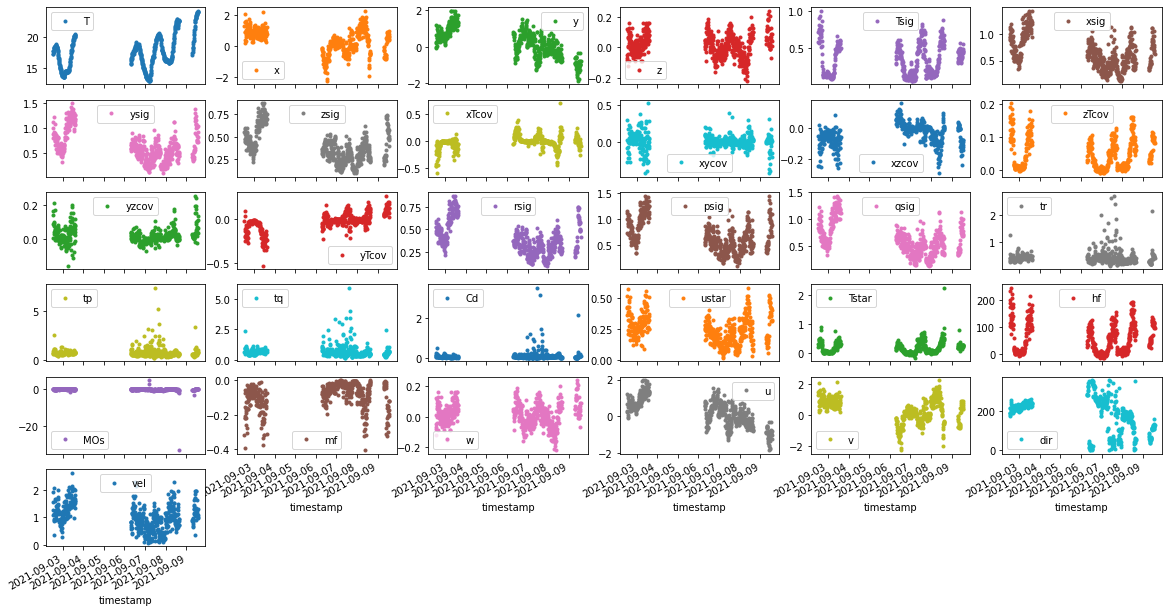

In [14]:
plt = sonic.plot(linestyle='None', marker=".", subplots=True, layout=(6,6),figsize=(20,11))

###  Read Friedrichs data from Operational System (8min sampling interval)
Data is stored in `.csv` files which are easy to read and plot. It's not the raw data that comes out of the logger but the one that has been interpolated onto 8 min intervalls including the addition of precip and sst data (https://git.geomar.de/sebastian-wahl/weatherdata)

In [17]:
#fields_roof = ['ff1','ff2','ff3','dd','t','rh','sol','dso','dss','rrds','rsum12h','sst']
use_columns = ['ff1','ff2','ff3','dd','t','rh','sol','rrds','sst']

# build a list of csv files that shall be used based on start_date and end_date
filelist = []
for d in pd.date_range(start_date, end_date):
    filelist.append(friedrichs_operational_indir+"roof_"+datetime.strftime(d,"%Y-%m-%d")+".csv")

# Load all the data into a python dataframe
# the [fields_roof] only adds the columns listed in `fields_roof`. 
# To get all fields, remove the [fields_roof] part
roof_operational_8m = (dd.read_csv(filelist,parse_dates=['timestamp']).set_index('timestamp').compute())[use_columns]
roof_operational_8m.to_csv(friedrichs_operational_output)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jkjellsson/Downloads/praktikum_summer_2021//friedrichs_operational/roof_2021-09-03.csv'

### Read data Friedrichs System set up for the Praktikum (1m sampling interval)
Again, data is stored in `.csv` files which are easy to read and plot.

In [35]:
dateparse = lambda x: datetime.strptime(x,'%d.%m.%Y %H:%M:%S')
#26.08.2020 00:27:00;   994,4;    -4,5;    16,0;    85,0;     3,7;     166;   355,1
tmplist = []
#for d in pd.date_range(start_date, end_date):
if 1:
    #filename=friedrichs_praktikum_indir+"praktikum_"+datetime.strftime(d,"%Y%m%d")+".csv"
    filename = friedrichs_praktikum_indir+"friedrichs_praktikum.LOG"
    print(filename)
    df = pd.read_csv(filename, sep='\t', decimal=',',
                     parse_dates=['TimeDate'], date_parser=dateparse)
    #                 names=['TimeDate','p','sol','t','rh','ff','dd','unknown']
    #                )
    tmplist.append(df.drop_duplicates(keep='first'))

roof_praktikum_1m = (pd.concat(tmplist,axis=0,ignore_index=True)).sort_values(by=['TimeDate']).set_index('TimeDate')
print(roof_praktikum_1m)
roof_praktikum_8m = roof_praktikum_1m.resample('8min',closed='right',label='right').mean()
roof_praktikum_8m.to_csv(friedrichs_praktikum_output)

/Users/jkjellsson/Downloads/praktikum_summer_2021//friedrichs_praktikum/friedrichs_praktikum.LOG
                     Name  Luftdruck  Strahlung CMP11  Temperatur  \
TimeDate                                                            
2021-09-05 05:55:00     1     1020.1             -5.0        12.9   
2021-09-05 05:56:00     1     1020.1             -5.0        12.9   
2021-09-05 05:57:00     1     1020.1             -5.0        12.9   
2021-09-05 05:58:00     1     1020.1             -5.0        12.9   
2021-09-05 05:59:00     1     1020.1             -5.0        12.9   
...                   ...        ...              ...         ...   
2021-09-09 15:40:00     1     1007.0            536.7        27.0   
2021-09-09 15:41:00     1     1007.0            529.9        27.1   
2021-09-09 15:42:00     1     1007.0            531.6        27.1   
2021-09-09 15:43:00     1     1006.9            532.1        27.1   
2021-09-09 15:44:00     1     1006.9            532.2        27.1   

     

###  Read Postprocessed data from Kiel lighthouse (8min sampling interval)
Again, data is stored in `.csv` files which are easy to read and plot.

In [15]:
# build a list of csv files that shall be used based on start_date and end_date
filelist = []
for d in pd.date_range(start_date, end_date):
    filelist.append(lighthouse_operational_indir+"lighthouse_"+datetime.strftime(d,"%Y-%m-%d")+".csv")

# Load all the data into a pandas dataframe, compute() converts from dask dataframe to a pandas dataframe
lighthouse_operational_8m = (dd.read_csv(filelist,parse_dates=['timestamp']).set_index('timestamp').compute())
lighthouse_operational_8m.to_csv(lighthouse_operational_output)